## Graph Neural Networks for property prediction

### Introduction
In recent years, there has been an increased interest in using machine-learning to perform *in-silico* evaluation of various molecular properties of interest. This is often done with quantitative structure-property relations (QSPRs) or property prediction models. The aim of this is reducing the experimental efforts and direct them to the most promising candidates only.

### Problem statement
In this notebook, you are tasked with developing a graph neural network based QSPR for predicting the boiling point temperature of organic compounds.


### Requirements
The following requirements must be met:
* use this notebook to conduct your solution
* include all steps from pre-processing, model development and evaluation
* use [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) for the GNN model
* choice of GNN model is up to you as long as it includes node and edge features
* No extensive hyperparameters optimization is needed.
* include relevant figures and metrics to evaluate the performance of your model
* use the following dataset: [Bradely Double Good + boiling point dataset](https://figshare.com/articles/dataset/Jean_Claude_Bradley_Double_Plus_Good_Highly_Curated_and_Validated_Melting_Point_Dataset/1031638)
    * the input is the *smiles* column and the target is the *mpC* column.   
* Compare the obtained results with the following two papers:
  * [Combining Group-Contribution Concept and Graph Neural Networks Toward Interpretable Molecular Property Models](https://pubs.acs.org/doi/full/10.1021/acs.jcim.2c01091)
  * [Application of interpretable group-embedded graph neural networks for pure compound properties](https://www.sciencedirect.com/science/article/pii/S0098135423001618)

### Solution

*write code and comments here*

In [77]:
!pip install rdkit
!pip install torch
!pip install torch-geometric

In [78]:
# import packages
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

# Atom Featurisation

In [79]:
import numpy as np
from rdkit import Chem

def one_hot_encoding(x, permitted_list):
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

def get_atom_features(atom, use_chirality=True, hydrogens_implicit=True):
    permitted_list_of_atoms = ['C', 'N', 'O', 'S', 'F', 'H']  # Include 'H' for implicit hydrogens

    # compute atom features
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    is_in_a_ring_enc = [int(atom.IsInRing())]
    is_aromatic_enc = [int(atom.GetIsAromatic())]

    # Additional features for melting point prediction
    atomic_mass_scaled = [float((atom.GetMass() - 10.812) / 116.092)]
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5) / 0.6)]
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64) / 0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


In [80]:
# def one_hot_encoding(x, permitted_list):

#     if x not in permitted_list:
#         x = permitted_list[-1]

#     binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

#     return binary_encoding

# def get_atom_features(atom, use_chirality = True, hydrogens_implicit = True):
#     """
#     Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
#     """

#     # define list of permitted atoms

#     permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

#     if hydrogens_implicit == False:
#         permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

#     # compute atom features

#     atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
#     n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
#     formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
#     hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

#     is_in_a_ring_enc = [int(atom.IsInRing())]

#     is_aromatic_enc = [int(atom.GetIsAromatic())]

#     atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

#     vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

#     covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

#     atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

#     if use_chirality == True:
#         chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
#         atom_feature_vector += chirality_type_enc

#     if hydrogens_implicit == True:
#         n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
#         atom_feature_vector += n_hydrogens_enc

#     return np.array(atom_feature_vector)

# Bond Featurisation


In [81]:

def get_bond_features(bond,  use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

# Generating labeled Pytorch Geometric Graph Objects



In [82]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):

    data_list = []

    for (smiles, y_val) in zip(x_smiles, y):

        # convert SMILES to RDKit mol object
        # mol = Chem.MolFromSmiles(smiles)
        mol = Chem.MolFromSmiles(smiles, sanitize=True)

        if mol is not None:  # Check if the conversion was successful
            try:
                Chem.Kekulize(mol)
            except ValueError as e:
                print(f"Error kekulizing SMILES: {smiles}. Error: {e}")
                print(f"Skipping this data point with problematic SMILES: {smiles}")
                continue
            n_nodes = mol.GetNumAtoms()
            n_edges = 2 * mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0, 1)))

            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2 * mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0, 1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = torch.zeros((n_nodes, n_node_features), dtype=torch.float)

            for atom in mol.GetAtoms():
                X[atom.GetIdx()] = torch.tensor(get_atom_features(atom), dtype=torch.float)

            # construct edge index array E of shape (2, n_edges)
            edge_index = torch.zeros((2, n_edges), dtype=torch.long)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            edge_index[0, :len(rows)] = torch.tensor(rows, dtype=torch.long)
            edge_index[1, :len(cols)] = torch.tensor(cols, dtype=torch.long)

            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = torch.zeros((n_edges, n_edge_features), dtype=torch.float)

            for k, (i, j) in enumerate(zip(rows, cols)):
                EF[k] = torch.tensor(get_bond_features(mol.GetBondBetweenAtoms(int(i), int(j))))

            # construct label tensor
            y_tensor = torch.tensor([y_val], dtype=torch.float)

            # construct PyTorch Geometric data object and append to data list
            data_list.append(Data(x=X, edge_index=edge_index, edge_attr=EF, y=y_tensor))
        else:
            continue
    return data_list

# Data pre-process

In [83]:
# Load the dataset from the Excel file using Pandas
import pandas as pd
url = '/content/drive/MyDrive/deep_learning/BradleyDoublePlusGoodMeltingPointDataset.xlsx'
df = pd.read_excel(url)

ATOM_REMOVE = ['Sn', 'As', 'Ti', 'Ca', 'Fe']
for i in ATOM_REMOVE:
      df.drop(df[df.smiles.str.contains(i)].index, inplace=True)
      df.reset_index(drop=True, inplace=True)

# Extract the SMILES and mpC columns
smiles = df['smiles']
mpC = df['mpC']
x =  smiles.isnull().sum().sum()
# Create PyTorch Geometric graph data
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles, mpC)

[21:26:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[21:26:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[21:26:58] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 31 32 33 34
[21:26:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[21:26:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[21:26:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[21:26:58] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[21:26:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[21:26:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[21:27:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[21:27:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[21:27:03] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[21:27:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[21:27:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[21:27:05] Can't kekulize mol.  Unkekuliz

In [84]:
# print(data_list)
print(data_list[0])
for i in data_list[0]:
  print(i)

Data(x=[5, 34], edge_index=[2, 10], edge_attr=[10, 10], y=[1])
('x', tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0103, 0.3333, 0.1579, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0103, 0.3333, 0.1579, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0103, 0.3333, 0.1579, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
    

# Training Loop


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import numpy as np
class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGNN, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        self.dropout = nn.Dropout(p=0.5)
        x = self.conv2(x, edge_index)
        # x = F.leaky_relu(x)

        # Global pooling to obtain a graph-level representation
        x = global_mean_pool(x, data.batch)

        return x


gnn_model = SimpleGNN(in_channels=34, hidden_channels=32, out_channels=1)



In [86]:
# # We will use pytorch and pytorch geometric for our task

# import torch
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
# from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# embedding_size = 64

# class GCN(torch.nn.Module):
#     def __init__(self):
#         # Init parent
#         super(GCN, self).__init__()
#         torch.manual_seed(42)

#         # GCN layers
#         self.initial_conv = GCNConv(79, embedding_size)
#         self.conv1 = GCNConv(embedding_size, embedding_size)
#         self.conv2 = GCNConv(embedding_size, embedding_size)
#         self.conv3 = GCNConv(embedding_size, embedding_size)

#         # Output layer
#         self.out = Linear(embedding_size*2, 1)

#     def forward(self, x, edge_index, batch_index):
#         # First Conv layer
#         hidden = self.initial_conv(x, edge_index)
#         hidden = F.tanh(hidden)

#         # Other Conv layers
#         hidden = self.conv1(hidden, edge_index)
#         hidden = F.tanh(hidden)
#         hidden = self.conv2(hidden, edge_index)
#         hidden = F.tanh(hidden)
#         hidden = self.conv3(hidden, edge_index)
#         hidden = F.tanh(hidden)

#         # Global Pooling (stack different aggregations)
#         hidden = torch.cat([gmp(hidden, batch_index),
#                             gap(hidden, batch_index)], dim=1)

#         # Apply a final (linear) classifier.
#         out = self.out(hidden)

#         return out, hidden

# model = GCN()
# print(model)
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [96]:
# create dataloader for training
dataloader = DataLoader(dataset = data_list, batch_size = 2**7)

# define loss function
loss_function = nn.MSELoss()
# loss_function = torch.optim.SGD()

# define optimiser
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 1e-4)

# loop over 10 training epochs
for epoch in range(2000):

    gnn_model.train()

    # loop over minibatches for training
    for (k, batch) in enumerate(dataloader):

        # compute current value of loss function via forward pass
        output = gnn_model(batch)
        # print(output)
        loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))

        # set past gradient to zero
        optimiser.zero_grad()
        # pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
        # print(loss_function_value)
        # compute current gradient via backward pass
        loss_function_value.backward()

        # update model weights using gradient and optimisation method
        optimiser.step()


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
<ipython-input-96-7b86c94b0eec>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))


# Resuilt

In [97]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(data_list, test_size=0.8, random_state=42)
# test_data = train_test_split(data_list, test_size=0.2, random_state=42)
gnn_model.eval()  # Set the model to evaluation mode

predictions = []

with torch.no_grad():
    for batch in test_data:
        output = gnn_model(batch)
        predictions.append(output.item())

# Convert predictions to a numpy array
predictions = np.array(predictions)


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'y' is the ground truth boiling point values in the test set
ground_truth = np.array([batch.y.item() for batch in test_data])
print(predictions)
# mse = mean_squared_error(ground_truth, predictions)
# mae = mean_absolute_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

# print(f'Mean Squared Error: {mse:.4f}')
# print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')


[ 72.08834839 109.84059143  95.92658997 ...  59.1968689  102.63365936
  66.59532166]
R-squared: 0.4761


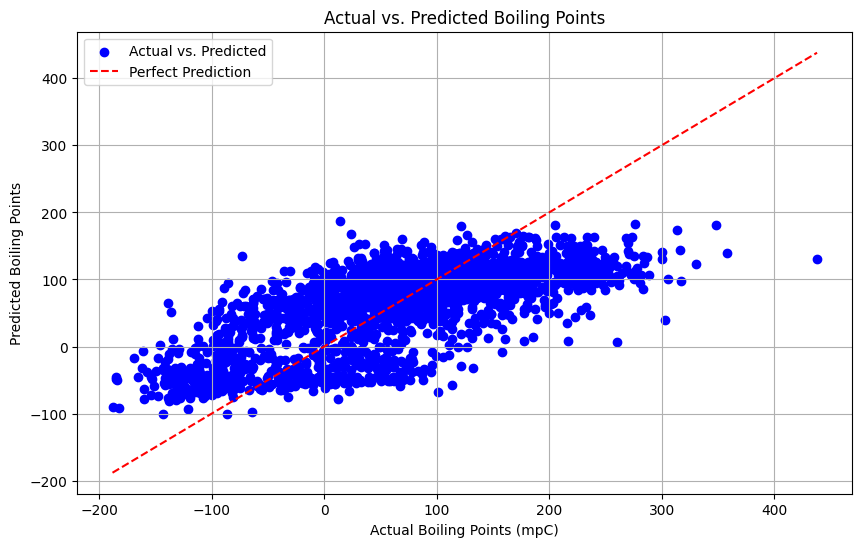

In [99]:
import matplotlib.pyplot as plt

# Assuming 'ground_truth' is the array of real boiling points and 'predictions' is the array of predicted values
# These values should be obtained during the evaluation phase

plt.figure(figsize=(10, 6))

plt.scatter(ground_truth, predictions, color='blue', label='Actual vs. Predicted')
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], linestyle='--', color='red', label='Perfect Prediction')

plt.title('Actual vs. Predicted Boiling Points')
plt.xlabel('Actual Boiling Points (mpC)')
plt.ylabel('Predicted Boiling Points')
plt.legend()
plt.grid(True)
plt.show()


The current model faces challenges attributed to insufficient data preprocessing and a relatively simplistic structure. A comparison with the models introduced in the literature, specifically ACG and GroupGAT, reveals noticeable disparities. These discrepancies can be attributed to the following issues:

### 1. **Data Preprocessing:**
   - **Feature Scaling:** Lack of normalize or standardize input features to achieve a consistent scale.

### 2. **Model Regularization:**
  - **L2 Regularization:** Did not apply a penalty term based on the magnitude of weights.
  - **Batch Normalization:** No stabilize and expedite training by normalizing layer inputs.

### 3. **Model Architecture:**
   - Compare to ACG and GroupGAT model, the model in this notebook is too simple.

### 4. **Hyperparameter Tuning:**
   - Experiment without different hyperparameter values.


By systematically addressing these aspects, we can enhance the model's performance through an iterative and informed approach to development. The emphasis lies on experimentation, rigorous evaluation, and continuous refinement of the graph neural network model.